In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal

In [2]:
#paramaters
#change all units to: force = pN, length = nm, time = ms
pars = {}
pars['a00'] = -21*10**-3
pars['a01'] = 0
pars['a10'] = 0
pars['a11'] = -1
pars['gamma0'] = 8.72
pars['gamma1'] = 54.8

pars['kbT'] = 4.1
pars['noise0'] = 2*pars['gamma0']*pars['kbT']
pars['noise1'] = 4.916*(1e3)

pars['delta_t'] = 0.01


In [3]:
def analytical_soln_acf_generic(omega_list, pars):

    autocorr_list = []
    for omega in omega_list:
        numerator = ( pars['a11']**2 * pars['noise0'] ) \
        + ( pars['a01']**2 * pars['noise1'] ) \
        + ( (omega**2) * (pars['gamma1']**2) * (pars['noise0']) )

        denominator = ( -2*pars['a11']*pars['a00']*pars['a10']*pars['a01'] ) \
        + ( (omega**2) * (pars['gamma0']**2) * (pars['a11']**2) ) \
        + ( ( (pars['a10']*pars['a01']) + (pars['gamma0']*pars['gamma1']* (omega**2) ) )**2) \
        + ( (pars['a00']**2) * ( (pars['a11']**2) + (omega**2) * (pars['gamma1']**2) ) )

        autocorr = numerator/denominator
        autocorr_list.append(autocorr)
    return autocorr_list

In [4]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x1 = 0
    x2 = 0
    x1_traj = []
    x2_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x1, x2
        x1_new = x1 + (pars['a00']/pars['gamma0'])*x1*pars['delta_t'] + \
        (pars['a01']/pars['gamma0'])*x2*pars['delta_t'] + \
        np.sqrt((pars['noise0'])/((pars['gamma0'])**2))*s1
                 
        x2_new = x2 + (pars['a11']/pars['gamma1'])*x2*pars['delta_t'] + \
        (pars['a10']/pars['gamma1'])*x1*pars['delta_t'] + \
        np.sqrt((pars['noise1'])/((pars['gamma1'])**2))*s2
                
        x1 = x1_new
        x2 = x2_new
        
        x1_traj.append(x1)
        x2_traj.append(x2)
    return x1_traj, x2_traj

In [5]:
def euler_n_traj(n_time, pars):
    time = np.arange(0, n_time, pars['delta_t'])
    len_time = len(time)
    #returns a list of euler trajectories
    x_traj_list = []
    y_traj_list = []
    for i in tqdm(range(pars['n_realizations'])):
        x_traj, y_traj = euler_one_traj(len_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [6]:
def plotter_traj(x_traj_list, y_traj_list):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))

    for x in x_traj_list:
        ax[0].plot(time, x)
    for y in y_traj_list:
        ax[1].plot(time, y)
    for x,y in zip(x_traj_list, y_traj_list):
        ax[2].plot(x,y)

    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')

    ax[1].set_xlabel('t')
    ax[1].set_ylabel('y')

    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

In [7]:
pars['n_realizations'] = 2
n_time = 100000
x_traj_list, y_traj_list, time = euler_n_traj(n_time, pars)

100%|██████████| 2/2 [04:00<00:00, 120.41s/it]


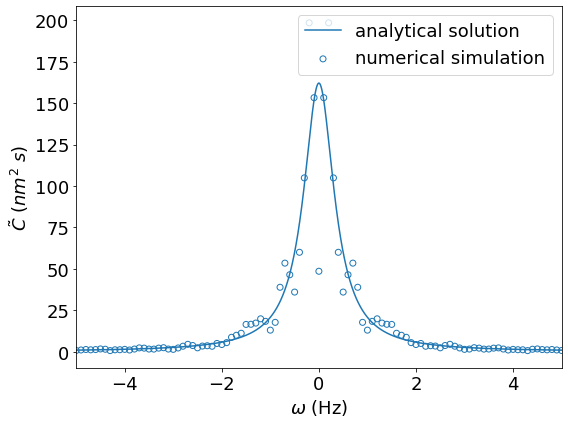

In [13]:
plt.figure(figsize=(8,6))
f, power_spectrum = signal.welch(x_traj_list[0], fs = 1/0.01, nperseg=1000000, return_onesided=False)

freq=[i*(1e3) for i in f]
scaled_freq = np.fft.fftshift(freq)

scaled_power_spectrum = np.fft.fftshift(power_spectrum)*(1e-3)
max_value = np.argmax(scaled_power_spectrum)
val = 100
plt.scatter(scaled_freq[max_value-val:max_value+val], scaled_power_spectrum[max_value-val:max_value+val], facecolors='none', \
            edgecolors='tab:blue', label='numerical simulation')

omega_analytical = np.arange(-40,40, 0.01)
paper_acf_soln = analytical_soln_acf_generic(omega_analytical/(1e3), pars)

plt.plot(omega_analytical/(2*np.pi), np.array(paper_acf_soln)/(1e3), label='analytical solution')
plt.xlim(-5,5)
plt.xlabel('$\omega$ (Hz)', fontsize=18)
plt.ylabel('$\~{C}$ ($nm^2$ $s$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(prop={'size': 18})
plt.tight_layout()
plt.savefig('simulation_lorentzian_fin.png', dpi=300)
plt.show()

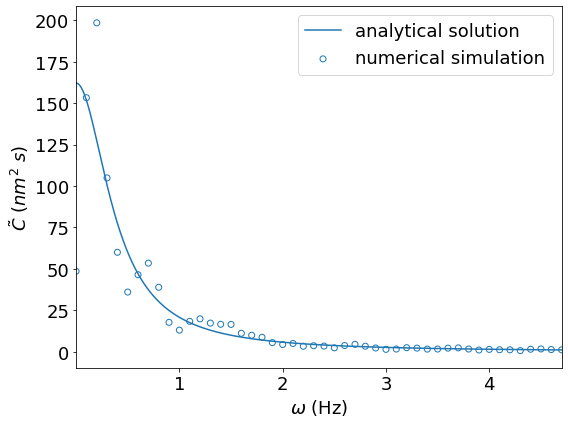

In [15]:
plt.figure(figsize=(8,6))
f, power_spectrum = signal.welch(x_traj_list[0], fs = 1/0.01, nperseg=1000000, return_onesided=False)

freq=[i*(1e3) for i in f]
scaled_freq = np.fft.fftshift(freq)

scaled_power_spectrum = np.fft.fftshift(power_spectrum)*(1e-3)
max_value = np.argmax(scaled_power_spectrum)
val = 100
plt.scatter(scaled_freq[max_value-val:max_value+val], scaled_power_spectrum[max_value-val:max_value+val], facecolors='none', \
            edgecolors='tab:blue', label='numerical simulation')

omega_analytical = np.arange(-40,40, 0.01)
paper_acf_soln = analytical_soln_acf_generic(omega_analytical/(1e3), pars)

plt.plot(omega_analytical/(2*np.pi), np.array(paper_acf_soln)/(1e3), label='analytical solution')
plt.xlim(0.001,4.7)
plt.xlabel('$\omega$ (Hz)', fontsize=18)
plt.ylabel('$\~{C}$ ($nm^2$ $s$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(prop={'size': 18})
plt.tight_layout()
plt.savefig('simulation_lorentzian_half_fin.png', dpi=300)
plt.show()

In [1]:
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.yscale('log')
omega_list = np.arange(-200,800, 0.01)

f, power_spectrum = signal.welch(x_traj_list[0], fs = 1/0.01, nperseg=1000000, return_onesided=False)

freq=[i*(1e3) for i in f]
scaled_freq = np.fft.fftshift(freq)

scaled_power_spectrum = np.fft.fftshift(power_spectrum)*(1e-3)
max_value = np.argmax(scaled_power_spectrum)
val = 1000
plt.scatter(scaled_freq[max_value-val:max_value+val], scaled_power_spectrum[max_value-val:max_value+val], facecolors='none', \
            edgecolors='tab:blue', label='numerical simulation')

omega_list = np.arange(-200,800, 0.01)
paper_acf_soln = analytical_soln_acf_generic(omega_list/(1e3), pars)
plt.plot(omega_list/(2*np.pi), np.array(paper_acf_soln)/(1e3), label='analytical solution')
plt.xlim(0.01,100)
plt.ylim(0.0001, 1000)

plt.xlabel('$\omega$ (Hz)', fontsize=18)
plt.ylabel('$\~{C}$ ($nm^2$ $s$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.xlim(0.03,100)
plt.legend(prop={'size': 18})
plt.tight_layout()
plt.savefig('simulation_lorentzian_loglog_fin.png', dpi=300)

# plt.xlim(-5,5)
plt.show()

NameError: name 'plt' is not defined